O data set utilizado contém informações da preferência dos usuários, com dados de 73.516 usuários sobre 12.294 anime. Cada usuário pode adicionar os anime que assistiu para sua lista de completados e dar a ele uma nota. Este data set é uma compilação destes dados. Os dados originais foram extraidos da API do site myanimelist.net 

<strong>Anime Dataset</strong>

Este dataset (anime) contém informações de 12.294 anime, e possui os seguintes 7 atributos:

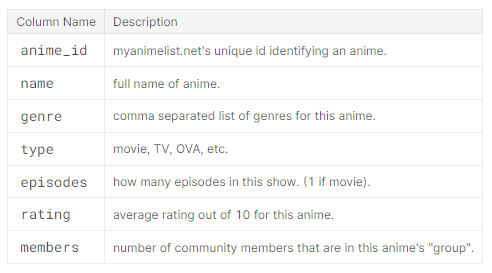

<strong>Rating Dataset</strong>

Este dataset (rating) contém 7.813.737 informações sobre os seguintes 3 atributos:

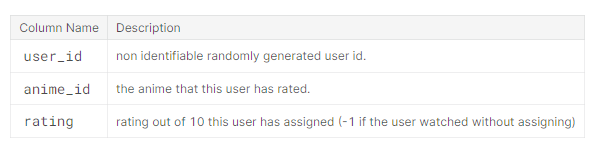

<strong>Objetivo</strong>

Este projeto tem como objetivo criar um sistema de recomendações de anime baseado apenas em anime similares.

 <strong>Libraries 📙 utilizadas no projeto:</strong>

In [9]:
import pandas as pd
import os
import numpy as np
import scipy as sp
import warnings

from sklearn.metrics.pairwise import cosine_similarity

pd.options.display.max_columns

warnings.filterwarnings("always")
warnings.filterwarnings("ignore")

 <strong>Determinando os File Paths: 📂</strong>

In [13]:
rating_path = "rating.csv"
anime_path = "anime.csv"

 <strong>Visualização inicial dos dados: 📂</strong>

In [14]:
rating_df = pd.read_csv(rating_path)
rating_df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [15]:
anime_df = pd.read_csv(anime_path)
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [16]:
print(f"anime set (row, col): {anime_df.shape}\n\nrating set (row, col): {rating_df.shape}")

anime set (row, col): (12294, 7)

rating set (row, col): (7813737, 3)


In [17]:
print("Anime:\n")
print(anime_df.info())
print("\n","*"*50,"\nRating:\n")
print(rating_df.info())

Anime:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB
None

 ************************************************** 
Rating:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB
None


 <strong>Trabalhando com os 'missing values', valores que não estão definidos ou estão claramente errados:📂</strong>

In [18]:
print("Anime missing values (%):\n")
print(round(anime_df.isnull().sum().sort_values(ascending=False)/len(anime_df.index),4)*100) 
print("\n","*"*50,"\n\nRating missing values (%):\n")
print(round(rating_df.isnull().sum().sort_values(ascending=False)/len(rating_df.index),4)*100)

Anime missing values (%):

rating      1.87
genre       0.50
type        0.20
anime_id    0.00
name        0.00
episodes    0.00
members     0.00
dtype: float64

 ************************************************** 

Rating missing values (%):

user_id     0.0
anime_id    0.0
rating      0.0
dtype: float64


<strong>Apenas o dataset de anime apresenta 'missing values'.</strong>

In [19]:
print(anime_df['type'].mode())
print(anime_df['genre'].mode())

0    TV
dtype: object
0    Hentai
dtype: object


<strong>Deletando os anime com 0 de rating e preenchendo os valores de gênero e tipo:</strong>

In [20]:
# deleting anime with 0 rating
anime_df=anime_df[~np.isnan(anime_df["rating"])]

# filling mode value for genre and type
anime_df['genre'] = anime_df['genre'].fillna(
anime_df['genre'].dropna().mode().values[0])

anime_df['type'] = anime_df['type'].fillna(
anime_df['type'].dropna().mode().values[0])

#checking if all null values are filled
anime_df.isnull().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

<strong>Substituindo os valores de rating '-1' anteriores (que significam que a pessoa não forneceu nenhuma nota). Então substituiremos os valores de '-1' por NaN:</strong>

In [21]:
rating_df['rating'] = rating_df['rating'].apply(lambda x: np.nan if x==-1 else x)
rating_df.head(20)

,user_id,anime_id,rating
0,1,20,NaN
1,1,24,NaN
2,1,79,NaN
3,1,226,NaN
4,1,241,NaN
5,1,355,NaN
6,1,356,NaN
7,1,442,NaN
8,1,487,NaN
9,1,846,NaN


<strong>Agora iremos organizar nosso Dataframe nos seguintes passos:</strong>
- Queremos recomendar apenas anime do gênero TV.
- Criamo um novo DF combinando ambos os anime e suas respectivas notas.
- O resultado final será com as informações de: user_id, name e rating.
- Iremos utilizar o DF baseado nos primeiros 12000 usuários.

In [41]:
#step 1
anime_df = anime_df[anime_df['type']=='TV']

#step 2
rated_anime = rating_df.merge(anime_df, left_on = 'anime_id', right_on = 'anime_id', suffixes= ['_user', ''])

#step 3
rated_anime =rated_anime[['user_id', 'name', 'rating']]

#step 4
rated_anime_12000= rated_anime[rated_anime.user_id <= 12000]
rated_anime_12000.head()

,user_id,name,rating
0,1,Naruto,7.81
1,3,Naruto,7.81
2,5,Naruto,7.81
3,6,Naruto,7.81
4,10,Naruto,7.81


<strong>Agora, criando uma Pivot Table de usuários(linhas) e os nomes(colunas). Essa tabela será utilizada no calculo da similaridade.</strong>

In [24]:
pivot = rated_anime_7500.pivot_table(index=['user_id'], columns=['name'], values='rating')
pivot.head()

name,.hack//Roots,.hack//Sign,.hack//Tasogare no Udewa Densetsu,009-1,07-Ghost,11eyes,12-sai.: Chicchana Mune no Tokimeki,3 Choume no Tama: Uchi no Tama Shirimasenka?,30-sai no Hoken Taiiku,91 Days,...,"Zone of the Enders: Dolores, I",Zukkoke Knight: Don De La Mancha,ef: A Tale of Melodies.,ef: A Tale of Memories.,gdgd Fairies,gdgd Fairies 2,iDOLM@STER Xenoglossia,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,6.49,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.11,NaN


<strong>Agora, iremos organizar a tabela através dos seguintes passos:</strong>
- Normalização dos valores
- Preencher os valores NaN com 0.
- Transpor o pivot para a próxima etapa.
- Eliminar linhas com os valores de 0 (sem nota)
- Usar o scipy para converter a matriz esparsa para o cálculo de similaridade.

In [25]:
# step 1
pivot_n = pivot.apply(lambda x: (x-np.mean(x))/(np.max(x)-np.min(x)), axis=1)

# step 2
pivot_n.fillna(0, inplace=True)

# step 3
pivot_n = pivot_n.T

# step 4
pivot_n = pivot_n.loc[:, (pivot_n != 0).any(axis=0)]

# step 5
piv_sparse = sp.sparse.csr_matrix(pivot_n.values)

<strong>Utilizando o modelo de similaridade de cosseno: (Cosine Similarity):</strong>
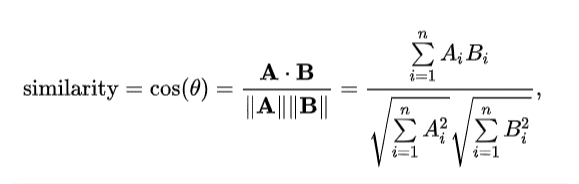
<strong>A similaridade de cosseno (Cosine Similarity) mede a similaridade entre dois vetores de um espaço de produto interno. É medido pelo cosseno do ângulo entre dois vetores e determina se dois vetores estão apontando aproximadamente na mesma direção.</strong>

In [26]:
#model based on anime similarity
anime_similarity = cosine_similarity(piv_sparse)

#Df of anime similarities
ani_sim_df = pd.DataFrame(anime_similarity, index = pivot_n.index, columns = pivot_n.index)

 
    Essa função irá retornar os 5 anime com o maior valor de similaridade com o show inserido, juntamente com o a porcentagem definida.
    
    examplo:
    >>>Input: 
    
    anime_recommendation('Death Note')
    
    >>>Output: 
    
    Recommended because you watched Death Note:

                    #1: Code Geass: Hangyaku no Lelouch, 57.35% match
                    #2: Code Geass: Hangyaku no Lelouch R2, 54.81% match
                    #3: Fullmetal Alchemist, 51.07% match
                    #4: Shingeki no Kyojin, 48.68% match
                    #5: Fullmetal Alchemist: Brotherhood, 45.99% match 

               
    

In [29]:
def anime_recommendation(ani_name):
  

    
    number = 1
    print('Recommended because you watched {}:\n'.format(ani_name))
    for anime in ani_sim_df.sort_values(by = ani_name, ascending = False).index[1:6]:
        print(f'#{number}: {anime}, {round(ani_sim_df[anime][ani_name]*100,2)}% match')
        number +=1  

<strong>Aqui é inserido o anime para o qual você quer recomendações, e então serão fornecidos
os 5 anime com maior taxa de similaridade com o escolhido.</strong>

In [50]:
anime_recommendation('Cowboy Bebop')

Recommended because you watched Cowboy Bebop:

#1: Samurai Champloo, 50.3% match
#2: Trigun, 48.65% match
#3: Neon Genesis Evangelion, 46.24% match
#4: Tengen Toppa Gurren Lagann, 45.1% match
#5: Code Geass: Hangyaku no Lelouch, 41.83% match
